# A Robust Measure of Central Tendency in $N$ Dimensions
_Charles C. Kankelborg_

## Abstract
I describe an N-dimensional generalization of the median that can be used to find the central tendency of a distribution. The generalized median is more robust than a centroid, is capable of sub-pixel precision, and can be computed quickly by FFT convolution. I have implemented the generalized median as a Python module for the special case of two dimensions, with an eye toward image processing. A few test cases are shown to illustrate the robustness of the method.


## The Median
We begin by describing the traditional median as follows:
$$
    x_m = \underset{x}{\arg \min} \,
        \int_{\mathcal{D}}  P(x')\, \left| x-x' \right| \,dx'
$$
where $\mathcal{D}$ is the support (domain) of the PDF $P(x)$. This is perhaps an atypical definition, but if you think about it you will realize that it is the median.

## The Generalized Median
By analogy to the previous section, we define the $N$-dimensional generalized median as follows:
$$
    \mathbf{r}_m = \underset{\mathbf{r}}{\arg \min} \,
        \int_{\mathcal{D}} P(\mathbf{r'})\,\left| \mathbf{r-r'} \right| \,d^N r'
        = \underset{\mathbf{r}}{\arg \min} \,\,P(\mathbf{r}) * \left|\mathbf{r}\right|.
$$


## Proposed Algorithm
By the following algorithm, the generalized median can run on an $N$-dimensional array in $\mathcal{O}\left(n\,\log n \right)$ time, where $n$ is the number of data points.
1. Begin with $P_{ij}$, a sampled array representation of $P(\mathbf{r})$.$^*$
1. Use FFT to convolve $P_{ij}$ with an array representation of the cone function, $\left| \mathbf{r} \right|$. Call the result $C_{ij}$, which of course represents a continuous function $C(\mathbf{r})$.
2. Find $(i_m,j_m)$, the index of the minimum entry in the array representation of $C(\mathbf{r})$. Its location is, to within the sampling interval, an approximation of $\mathbf{r}_m$.
3. Using a local neighborhood of perhaps $3^N$ pixels surrounding $(i_m,j_m)$, fit a quadratic form to $C_{ij}$ and minimize it to obtain a sub-pixel estimate of $\mathbf{r}_m$.

$^*$ I write just two indices because I am thinking about images, but in general my proposed algorithm can be implemented in $N$ dimensions.

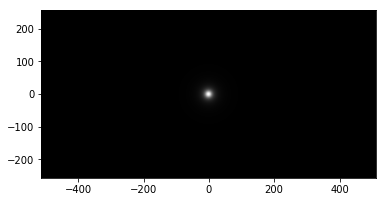

generalized median:  1.907843965490648e-13 -2.4910392067446473e-13
centroid:  3.5647405458753576e-16 -2.251415081605489e-16
equivalent radius: 19.017071110115342
mean abs radius:  56.75138084957386
RMS radius: 96.39281129969413


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gm

# Coordinates for test images
Nx = 512
Ny = 256
x = np.arange(-Nx,Nx+1)
y = np.arange(-Ny,Ny+1)
xs,ys = np.meshgrid(x,y)
rs = np.sqrt(xs**2 + ys**2)
# Specify correct extent for plt.imshow(... origin='lower')
extent = (x[0]-0.5,x[-1]+0.5,y[0]-0.5,y[-1]+0.5)

# Test image 1, precisely centered
test1 = 1./(1+(rs/10.)**2.5)
imgplot = plt.imshow(test1, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')
plt.show()
(jm1,im1,delta_x1,delta_y1,meanabsrad1) = gm.gm2d(test1)

print('generalized median: ',x[jm1]+delta_x1,y[im1]+delta_y1)

# Compare moments
xc1 = np.sum(xs*test1)/np.sum(test1)
yc1 = np.sum(ys*test1)/np.sum(test1)
print('centroid: ',xc1,yc1)
rmsrad1 = np.sqrt(  np.sum( ( ( xs-xc1)**2 + (ys-yc1)**2 ) * test1 ) / np.sum(test1)  )

# Measures of width:
equivrad1 = np.sqrt( np.sum(test1)/np.amax(test1)/np.pi )
print('equivalent radius:',equivrad1)
print('mean abs radius: ',meanabsrad1)
print('RMS radius:',rmsrad1)



true spot center:  -327 102
generalized median:  -326.36883237939605 101.38157023638097
centroid:  -318.0430991539659 95.5785331767498
equivalent radius: 18.747975030984097
mean abs radius:  52.13155926579982
RMS radius: 92.70242404066751


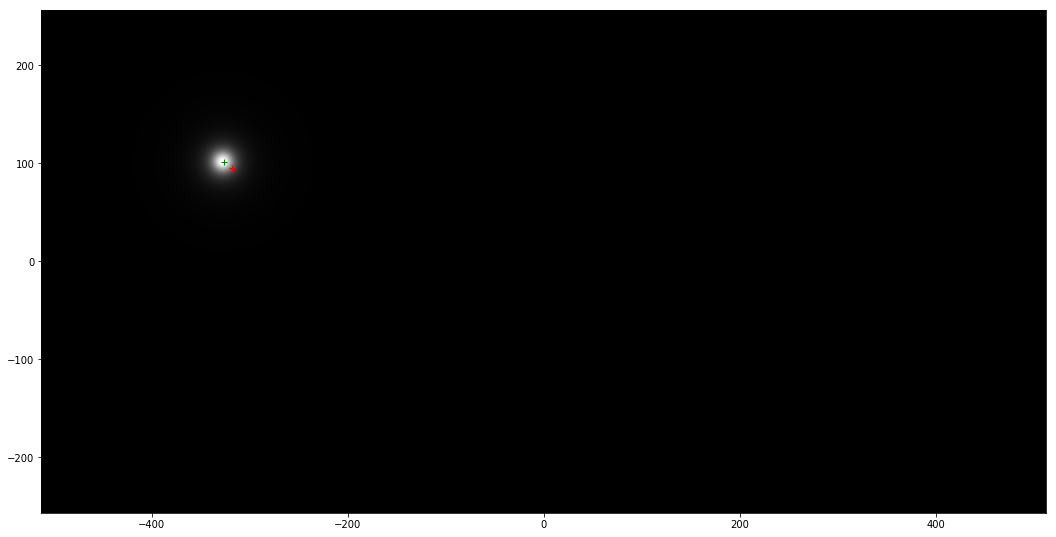

In [2]:
# Test image 2, strongly offset from center
xtrue = -327
ytrue = +102
rs2 = np.sqrt((xs-xtrue)**2 + (ys-ytrue)**2)
test2 = 1./(1+(rs2/10.)**2.5)

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test2, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# First, give the true center value
print('true spot center: ',xtrue,ytrue)

# Generalized median calculation
(jm2,im2,delta_x2,delta_y2,meanabsrad2) = gm.gm2d(test2)
xgm2 = x[jm2]+delta_x2
ygm2 = y[im2]+delta_y2
print('generalized median: ',xgm2,ygm2)

# Compare moments
xc2 = np.sum(xs*test2)/np.sum(test2)
yc2 = np.sum(ys*test2)/np.sum(test2)
print('centroid: ',xc2,yc2)
rmsrad2 = np.sqrt(  np.sum( ( ( xs-xc2)**2 + (ys-yc2)**2 ) * test2 ) / np.sum(test2)  )

# Measures of width:
equivrad2 = np.sqrt( np.sum(test2)/np.amax(test2)/np.pi )
print('equivalent radius:',equivrad2)
print('mean abs radius: ',meanabsrad2)
print('RMS radius:',rmsrad2)

# Overplot stats
plt.plot(xc2,yc2,'r+',xgm2,ygm2,'g+')
plt.show()

true cluster center:  -327 102
generalized median:  -325.3735924451872 100.36404127187268
centroid:  -317.924128435217 95.44021752805236
equivalent radius: 31.98265768873919
mean abs radius:  64.38640743637947
RMS radius: 97.19660533773553


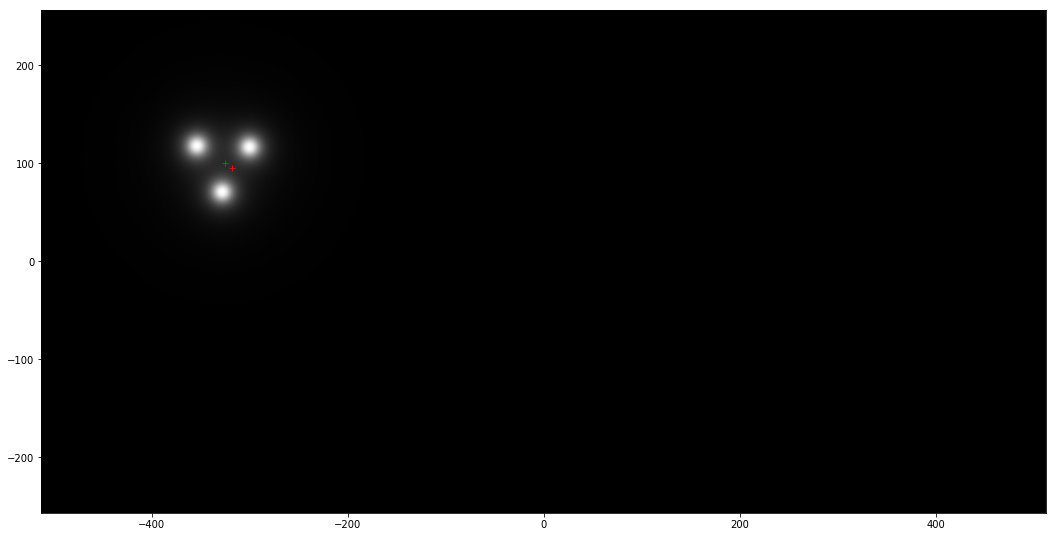

In [3]:
# Now test with three sources, arranged in an equilateral triangle.
test3 = test1*0. # start from a clean slate.
rsrc = 31.
thetasrc = np.array([0,1./3.,2./3.]) * 2.*np.pi + 0.5
xsrc = rsrc * np.cos(thetasrc) + xtrue
ysrc = rsrc * np.sin(thetasrc) + ytrue
for i in range(3):
    rs3 = np.sqrt((xs-xsrc[i])**2 + (ys-ysrc[i])**2)
    test3 = test3 + 1./(1+(rs3/10.)**2.5)

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test3, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# First, give the true center value
print('true cluster center: ',xtrue,ytrue)

# Generalized median calculation
(jm3,im3,delta_x3,delta_y3,meanabsrad3) = gm.gm2d(test3)
xgm3 = x[jm3]+delta_x3
ygm3 = y[im3]+delta_y3
print('generalized median: ',xgm3,ygm3)

# Compare moments
xc3 = np.sum(xs*test3)/np.sum(test3)
yc3 = np.sum(ys*test3)/np.sum(test3)
print('centroid: ',xc3,yc3)
rmsrad3 = np.sqrt(  np.sum( ( ( xs-xc3)**2 + (ys-yc3)**2 ) * test3 ) / np.sum(test3)  )

# Measures of width:
equivrad3 = np.sqrt( np.sum(test3)/np.amax(test3)/np.pi )
print('equivalent radius:',equivrad3)
print('mean abs radius: ',meanabsrad3)
print('RMS radius:',rmsrad3)

# Overplot stats
plt.plot(xc3,yc3,'r+',xgm3,ygm3,'g+')
plt.show()

min pixel value (counts):  -48.573426002586075
max pixel value (counts):  352.6562251616741
bias (counts):  0.6310253736527349
true cluster center:  -327 102
generalized median:  -313.3550825166318 95.92484234924123
centroid:  -239.78114362871673 72.168936175175
equivalent radius: 34.4902061402205
mean abs radius:  149.96404772892384
RMS radius: 233.84940842262478


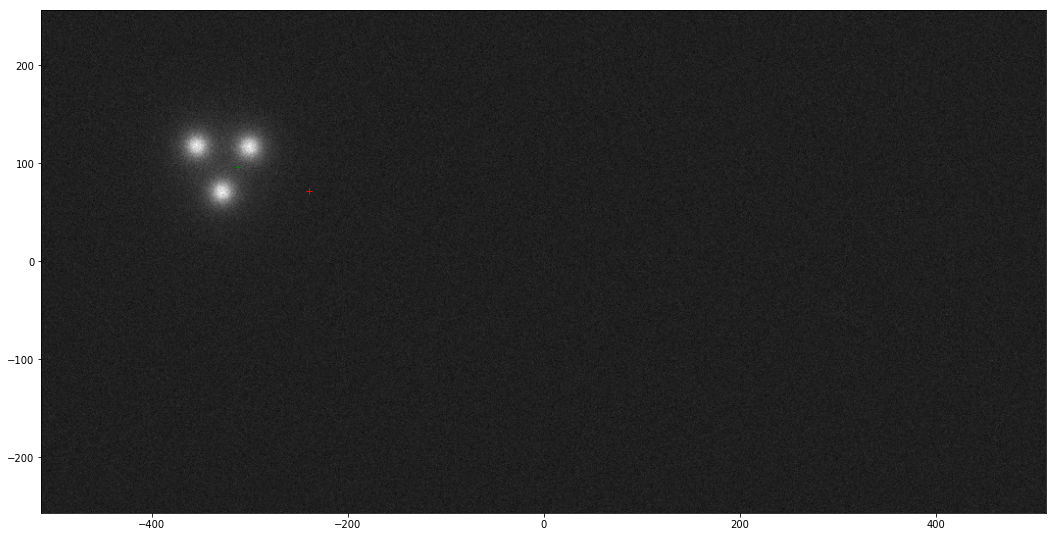

In [12]:
# Test with shot noise and read noise, including negative pixels
counts = 3e2     # Approx max count rate
sigma_read = 10  # RMS read noise (counts; e.g. 10 counts = 10 electrons visible)
bias = 0.5*np.random.randn() # Uniform unsubtracted background
readnoise = sigma_read * np.random.standard_normal(test3.shape)
test4 = np.random.poisson(counts*test3, test3.shape) + readnoise + bias

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test4, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# Give the true center value, and some useful stats
print('min pixel value (counts): ', np.amin(test4))
print('max pixel value (counts): ', np.amax(test4))
print('bias (counts): ',bias)
print('true cluster center: ',xtrue,ytrue)

# Generalized median calculation
(jm4,im4,delta_x4,delta_y4,meanabsrad4) = gm.gm2d(test4)
xgm4 = x[jm4]+delta_x4
ygm4 = y[im4]+delta_y4
print('generalized median: ',xgm4,ygm4)

# Compare moments
xc4 = np.sum(xs*test4)/np.sum(test4)
yc4 = np.sum(ys*test4)/np.sum(test4)
print('centroid: ',xc4,yc4)
rmsrad4 = np.sqrt(  np.sum( ( ( xs-xc4)**2 + (ys-yc4)**2 ) * test4 ) / np.sum(test4)  )

# Measures of width:
equivrad4 = np.sqrt( np.sum(test4)/np.amax(test4)/np.pi )
print('equivalent radius:',equivrad4)
print('mean abs radius: ',meanabsrad4)
print('RMS radius:',rmsrad4)

# Overplot stats
plt.plot(xc4,yc4,'r+',xgm4,ygm4,'g+')
plt.show()



## To do
1. [x] Write python module.
1. [x] Write a few test cases.
1. [x] Is the generalized median applicable to images with negative data values?
